# Projet UV IMDA   ------ GU Shiyun, WU Yingqi

# Génération d’images à partir d’un label

- DataBase initial ： https://www.kaggle.com/datasets/moltean/fruits



### Puisque chaque classe du jeu de données d’origine ne contenait qu’environ 500 images, nous avons fusionné deux classes correspondant au même fruit.
### Au final, nous avons sélectionné 11 catégories de fruits, avec environ 1 100 images par catégorie.
### Le jeu de données final organisé est disponible dans le lien ci-dessous.**

- Database prétraité : https://drive.google.com/drive/folders/1J037ySeZ0z3Ljbr_USWy1OaDhRrRUrtB?usp=sharing



# ACGAN : version de base

## Enfin, on utilise cette version pour visualiser enfin le meilleur résultat.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

### Pré-traitement des données & taille des images

- ACGAN.ipynb

Resize(128) direct.

RandomHorizontalFlip, ToTensor, Normalize([0.5]*3, [0.5]*3).

- fruit.ipynb

Resize(72) puis RandomCrop(64) → un peu plus d’augmentation de données.

RandomHorizontalFlip, ToTensor, Normalize identique.

👉 Différence :

ACGAN : simple redimensionnement.

fruit : Resize + RandomCrop pour plus de variété, et résolution finale plus basse (64×64).

In [2]:
# 数据根目录（刚刚解压的位置）
DATA_ROOT = "D:/IMDA CL3/Projet Fruit/data"

img_size = 64
batch_size = 64


transform = transforms.Compose([
    transforms.Resize(72),
    transforms.RandomCrop(img_size),          # 随机裁剪一点
    transforms.RandomHorizontalFlip(),        # 左右翻转
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


train_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_ROOT, "Training"),
    transform=transform
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_ROOT, "Valid"),
    transform=transform
)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("num_classes:", num_classes)
print("样本数:", len(train_dataset))

train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True
)


Classes: ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
num_classes: 11
样本数: 8902


### (Generator)

- ACGAN.ipynb

Conditionnement : bruit + embedding des labels (nn.Embedding(num_classes, embed_dim)), donc les labels sont projetés dans un espace continu de petite dimension.

Entrée réelle du réseau : [bruit (nz) || vecteur_emb (embed_dim)] puis reshape en [N, nz+embed_dim, 1, 1].

Sortie : images en 128×128.

- fruit.ipynb

Conditionnement : bruit + one-hot des labels (F.one_hot(labels, num_classes)), concaténés directement.

Entrée réelle du réseau : [bruit (z_dim) || one_hot (num_classes)] puis reshape en [N, z_dim+num_classes, 1, 1].

Sortie : images en 64×64.

- Différences clés :

Même idée (bruit + label), mais embedding vs one-hot.

Résolution : ACGAN travaille en 128×128, fruit en 64×64

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, g_channels=64):
        super().__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes

        # one-hot 方案：用 nn.Embedding 也可以，这里用简单版
        self.embed = nn.Embedding(num_classes, num_classes)

        input_dim = z_dim + num_classes  # 拼在一起作为输入

        self.net = nn.Sequential(
            # [B, input_dim, 1, 1]
            nn.ConvTranspose2d(input_dim, g_channels*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(g_channels*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_channels*8, g_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_channels*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_channels*4, g_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_channels*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_channels*2, g_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_channels),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_channels, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # 输出范围 [-1, 1]
        )

    def forward(self, z, y):
        # z: [B, z_dim], y: [B]
        y_onehot = torch.nn.functional.one_hot(
            y, num_classes=self.num_classes).float()
        x = torch.cat([z, y_onehot], dim=1)  # [B, z_dim + num_classes]
        x = x.view(x.size(0), -1, 1, 1)
        img = self.net(x)
        return img

### Discriminateur (Discriminator)

- ACGAN.ipynb

Backbone : plusieurs couches de Conv2d avec stride 2 pour descendre jusqu’à un petit feature map.

Deux “têtes” convolutives :

adv_head (Conv2d → 1 canal) pour real/fake.

cls_head (Conv2d → num_classes) pour la classe.

On view le résultat pour obtenir [N] et [N, num_classes].

- fruit.ipynb

Backbone : aussi des Conv2d pour réduire la taille spatiale.

Ensuite : Flatten() → un gros vecteur par image.

Deux têtes linéaires (Linear) :

adv_head : Linear → 1 (real/fake).

cls_head : Linear → num_classes (classe).

👉 Différence principale :

ACGAN : têtes 100 % conv.

fruit : têtes Flatten + Linear, plus “classiques” type MLP.

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, d_channels=64):
        super().__init__()
        self.num_classes = num_classes

        self.features = nn.Sequential(
            # 输入 [B, 3, 64, 64]
            nn.Conv2d(3, d_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels, d_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_channels*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels*2, d_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_channels*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels*4, d_channels*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_channels*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.flatten = nn.Flatten()
        # 判别头：real / fake
        self.adv_head = nn.Linear(d_channels*8*4*4, 1)
        # 分类头：水果类别
        self.cls_head = nn.Linear(d_channels*8*4*4, num_classes)

    def forward(self, x):
        feat = self.features(x)
        feat = self.flatten(feat)
        adv_out = self.adv_head(feat)    # 用 BCEWithLogitsLoss
        cls_out = self.cls_head(feat)    # 用 CrossEntropyLoss
        return adv_out, cls_out


In [5]:
import torch
print("torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("is_available:", torch.cuda.is_available())


torch: 2.5.1
torch.version.cuda: 12.1
is_available: True


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

z_dim = 100

G = Generator(z_dim, num_classes).to(device)
D = Discriminator(num_classes).to(device)

opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce = nn.BCEWithLogitsLoss()
ce = nn.CrossEntropyLoss()


device: cuda


In [9]:
! pip install tqdm  


In [10]:
from tqdm.notebook import tqdm

In [9]:
! pip install ipywidgets

Sur vraies images :

BCE(real → 1) (adv).

CE(labels réels) (classe).

Sur fausses images :

BCE(fake → 0) (adv).

Pas de perte de classification sur les fakes.

Donc : loss_D = adv_real + adv_fake + cls_real.

👉 Différence clé :

ACGAN supervise la classe des fakes dans D (cls_fake).

fruit ne fait la classification que sur les vraies images.

In [11]:
import math

OUTPUT_DIR = "D:/IMDA CL3/Projet Fruit/result"
os.makedirs(OUTPUT_DIR, exist_ok=True)

num_epochs = 200  # 可以先小一点测试，后面再加

fixed_z = torch.randn( num_classes * 4, z_dim, device=device)              # 为了观察训练进展
fixed_labels = torch.arange(num_classes, device=device).repeat_interleave(4)

for epoch in range(1, num_epochs + 1):
    G.train()
    D.train()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    for i, (real_imgs, labels) in enumerate(pbar):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        bsz = real_imgs.size(0)

        valid = torch.ones(bsz, 1, device=device)
        fake = torch.zeros(bsz, 1, device=device)

        # ======= 训练 D =======
        opt_D.zero_grad()
        d_real_adv, d_real_cls = D(real_imgs)
        loss_d_real_adv = bce(d_real_adv, valid)
        loss_d_real_cls = ce(d_real_cls, labels)

        z = torch.randn(bsz, z_dim, device=device)
        cond_labels = torch.randint(0, num_classes, (bsz,), device=device)
        fake_imgs = G(z, cond_labels).detach()

        d_fake_adv, _ = D(fake_imgs)
        loss_d_fake_adv = bce(d_fake_adv, fake)

        loss_D = loss_d_real_adv + loss_d_fake_adv + loss_d_real_cls
        loss_D.backward()
        opt_D.step()

        # ======= 训练 G =======
        opt_G.zero_grad()
        z = torch.randn(bsz, z_dim, device=device)
        cond_labels = torch.randint(0, num_classes, (bsz,), device=device)
        gen_imgs = G(z, cond_labels)

        g_adv, g_cls = D(gen_imgs)
        loss_g_adv = bce(g_adv, valid)
        loss_g_cls = ce(g_cls, cond_labels)

        loss_G = loss_g_adv + loss_g_cls
        loss_G.backward()
        opt_G.step()

        # 在进度条右边显示当前 loss
        pbar.set_postfix({
            "D_loss": f"{loss_D.item():.3f}",
            "G_loss": f"{loss_G.item():.3f}"
        })

    # epoch 结束后保存可视化图片 & 模型（和之前一样写在这里）
    G.eval()
    with torch.no_grad():
        fake_imgs = G(fixed_z, fixed_labels)
        fake_imgs = (fake_imgs + 1) / 2
        grid_path = os.path.join(OUTPUT_DIR, f"epoch_{epoch:03d}.png")
        vutils.save_image(fake_imgs, grid_path, nrow=4)
        print("保存样例到:", grid_path)

    torch.save(G.state_dict(), os.path.join(OUTPUT_DIR, f"G_epoch_{epoch:03d}.pth"))
    torch.save(D.state_dict(), os.path.join(OUTPUT_DIR, f"D_epoch_{epoch:03d}.pth"))

Epoch 1/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_001.png


Epoch 2/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_002.png


Epoch 3/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_003.png


Epoch 4/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_004.png


Epoch 5/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_005.png


Epoch 6/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_006.png


Epoch 7/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_007.png


Epoch 8/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_008.png


Epoch 9/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_009.png


Epoch 10/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_010.png


Epoch 11/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_011.png


Epoch 12/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_012.png


Epoch 13/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_013.png


Epoch 14/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_014.png


Epoch 15/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_015.png


Epoch 16/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_016.png


Epoch 17/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_017.png


Epoch 18/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_018.png


Epoch 19/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_019.png


Epoch 20/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_020.png


Epoch 21/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_021.png


Epoch 22/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_022.png


Epoch 23/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_023.png


Epoch 24/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_024.png


Epoch 25/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_025.png


Epoch 26/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_026.png


Epoch 27/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_027.png


Epoch 28/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_028.png


Epoch 29/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_029.png


Epoch 30/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_030.png


Epoch 31/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_031.png


Epoch 32/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_032.png


Epoch 33/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_033.png


Epoch 34/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_034.png


Epoch 35/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_035.png


Epoch 36/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_036.png


Epoch 37/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_037.png


Epoch 38/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_038.png


Epoch 39/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_039.png


Epoch 40/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_040.png


Epoch 41/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_041.png


Epoch 42/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_042.png


Epoch 43/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_043.png


Epoch 44/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_044.png


Epoch 45/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_045.png


Epoch 46/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_046.png


Epoch 47/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_047.png


Epoch 48/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_048.png


Epoch 49/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_049.png


Epoch 50/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_050.png


Epoch 51/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_051.png


Epoch 52/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_052.png


Epoch 53/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_053.png


Epoch 54/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_054.png


Epoch 55/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_055.png


Epoch 56/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_056.png


Epoch 57/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_057.png


Epoch 58/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_058.png


Epoch 59/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_059.png


Epoch 60/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_060.png


Epoch 61/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_061.png


Epoch 62/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_062.png


Epoch 63/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_063.png


Epoch 64/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_064.png


Epoch 65/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_065.png


Epoch 66/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_066.png


Epoch 67/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_067.png


Epoch 68/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_068.png


Epoch 69/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_069.png


Epoch 70/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_070.png


Epoch 71/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_071.png


Epoch 72/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_072.png


Epoch 73/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_073.png


Epoch 74/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_074.png


Epoch 75/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_075.png


Epoch 76/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_076.png


Epoch 77/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_077.png


Epoch 78/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_078.png


Epoch 79/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_079.png


Epoch 80/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_080.png


Epoch 81/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_081.png


Epoch 82/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_082.png


Epoch 83/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_083.png


Epoch 84/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_084.png


Epoch 85/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_085.png


Epoch 86/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_086.png


Epoch 87/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_087.png


Epoch 88/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_088.png


Epoch 89/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_089.png


Epoch 90/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_090.png


Epoch 91/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_091.png


Epoch 92/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_092.png


Epoch 93/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_093.png


Epoch 94/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_094.png


Epoch 95/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_095.png


Epoch 96/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_096.png


Epoch 97/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_097.png


Epoch 98/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_098.png


Epoch 99/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_099.png


Epoch 100/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_100.png


Epoch 101/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_101.png


Epoch 102/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_102.png


Epoch 103/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_103.png


Epoch 104/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_104.png


Epoch 105/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_105.png


Epoch 106/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_106.png


Epoch 107/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_107.png


Epoch 108/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_108.png


Epoch 109/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_109.png


Epoch 110/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_110.png


Epoch 111/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_111.png


Epoch 112/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_112.png


Epoch 113/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_113.png


Epoch 114/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_114.png


Epoch 115/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_115.png


Epoch 116/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_116.png


Epoch 117/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_117.png


Epoch 118/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_118.png


Epoch 119/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_119.png


Epoch 120/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_120.png


Epoch 121/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_121.png


Epoch 122/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_122.png


Epoch 123/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_123.png


Epoch 124/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_124.png


Epoch 125/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_125.png


Epoch 126/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_126.png


Epoch 127/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_127.png


Epoch 128/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_128.png


Epoch 129/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_129.png


Epoch 130/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_130.png


Epoch 131/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_131.png


Epoch 132/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_132.png


Epoch 133/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_133.png


Epoch 134/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_134.png


Epoch 135/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_135.png


Epoch 136/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_136.png


Epoch 137/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_137.png


Epoch 138/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_138.png


Epoch 139/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_139.png


Epoch 140/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_140.png


Epoch 141/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_141.png


Epoch 142/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_142.png


Epoch 143/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_143.png


Epoch 144/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_144.png


Epoch 145/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_145.png


Epoch 146/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_146.png


Epoch 147/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_147.png


Epoch 148/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_148.png


Epoch 149/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_149.png


Epoch 150/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_150.png


Epoch 151/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_151.png


Epoch 152/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_152.png


Epoch 153/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_153.png


Epoch 154/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_154.png


Epoch 155/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_155.png


Epoch 156/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_156.png


Epoch 157/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_157.png


Epoch 158/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_158.png


Epoch 159/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_159.png


Epoch 160/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_160.png


Epoch 161/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_161.png


Epoch 162/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_162.png


Epoch 163/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_163.png


Epoch 164/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_164.png


Epoch 165/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_165.png


Epoch 166/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_166.png


Epoch 167/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_167.png


Epoch 168/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_168.png


Epoch 169/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_169.png


Epoch 170/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_170.png


Epoch 171/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_171.png


Epoch 172/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_172.png


Epoch 173/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_173.png


Epoch 174/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_174.png


Epoch 175/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_175.png


Epoch 176/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_176.png


Epoch 177/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_177.png


Epoch 178/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_178.png


Epoch 179/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_179.png


Epoch 180/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_180.png


Epoch 181/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_181.png


Epoch 182/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_182.png


Epoch 183/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_183.png


Epoch 184/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_184.png


Epoch 185/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_185.png


Epoch 186/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_186.png


Epoch 187/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_187.png


Epoch 188/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_188.png


Epoch 189/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_189.png


Epoch 190/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_190.png


Epoch 191/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_191.png


Epoch 192/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_192.png


Epoch 193/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_193.png


Epoch 194/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_194.png


Epoch 195/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_195.png


Epoch 196/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_196.png


Epoch 197/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_197.png


Epoch 198/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_198.png


Epoch 199/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_199.png


Epoch 200/200:   0%|          | 0/140 [00:00<?, ?it/s]

保存样例到: D:/IMDA CL3/Projet Fruit/result\epoch_200.png


In [13]:
print(train_dataset.class_to_idx)  # 看清楚每个水果对应的 id

{'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


In [14]:
G.eval()
with torch.no_grad():
    class_name = "Papaya"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)


保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Papaya_samples.png


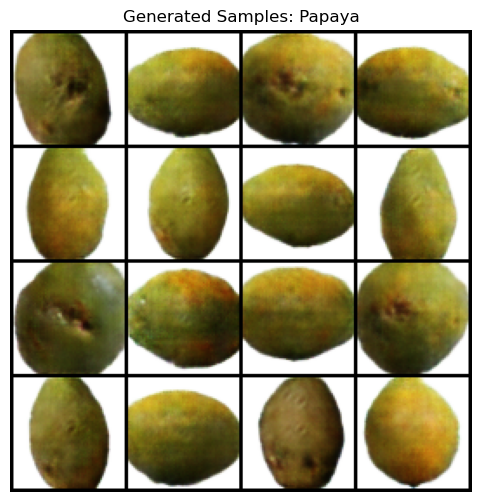

In [15]:
# ===========================
# 🔍 直接在 Notebook 显示结果
# ===========================

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()


保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Apple_samples.png


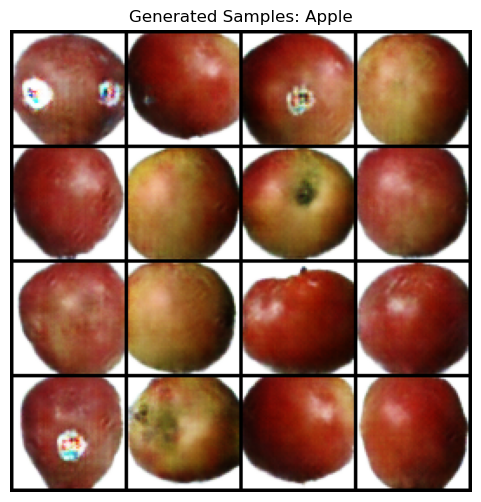

In [16]:
G.eval()
with torch.no_grad():
    class_name = "Apple"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()

保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Banana_samples.png


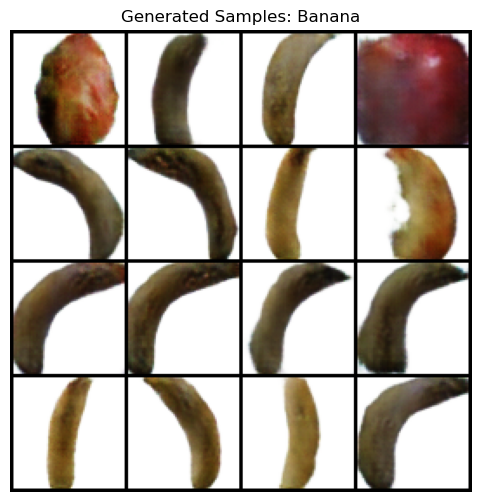

In [51]:
G.eval()
with torch.no_grad():
    class_name = "Banana"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()

保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Avocado_samples.png


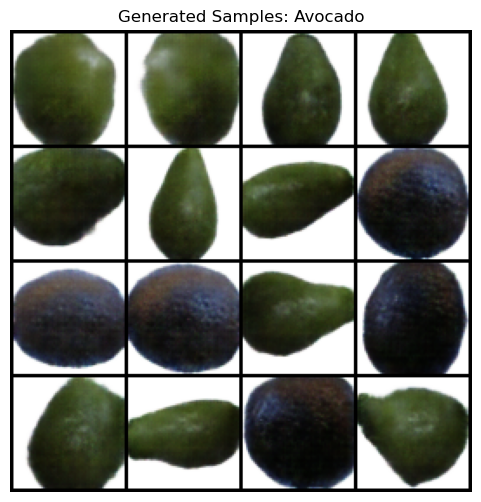

In [20]:
G.eval()
with torch.no_grad():
    class_name = "Avocado"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()

保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Blackberry_samples.png


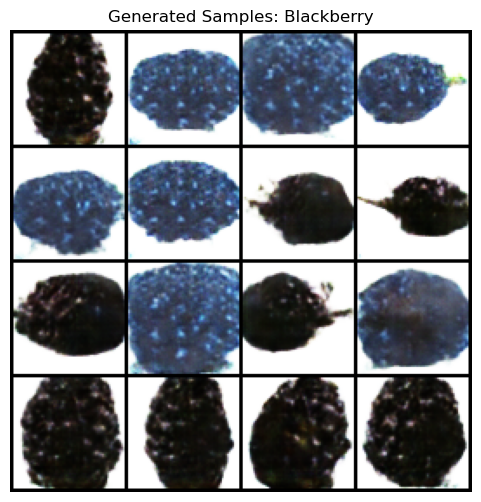

In [21]:
G.eval()
with torch.no_grad():
    class_name = "Blackberry"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()

保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Cherry_samples.png


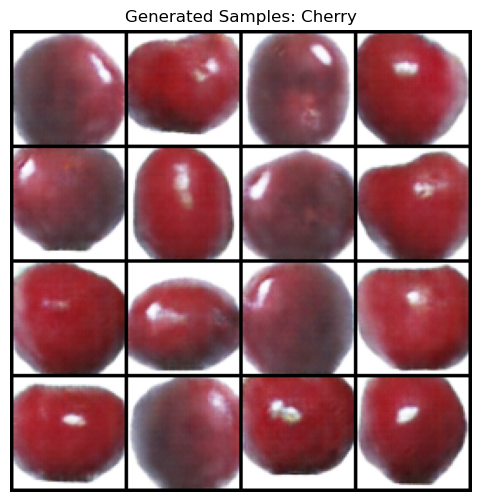

In [22]:
G.eval()
with torch.no_grad():
    class_name = "Cherry"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()

保存条件生成结果到: D:/IMDA CL3/Projet Fruit/result\Grape_samples.png


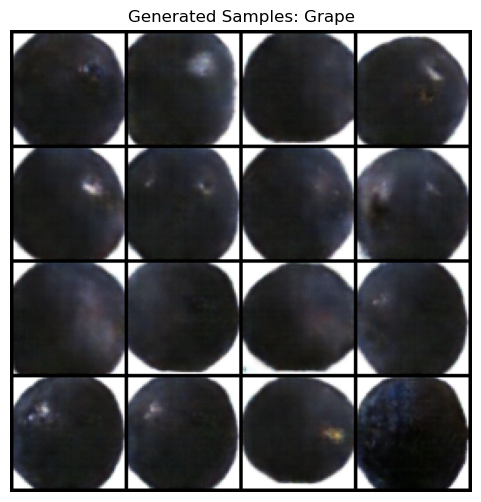

In [23]:
G.eval()
with torch.no_grad():
    class_name = "Grape"
    class_id = train_dataset.class_to_idx[class_name]

    n_samples = 16
    y = torch.full((n_samples,), class_id, device=device, dtype=torch.long)
    z = torch.randn(n_samples, z_dim, device=device)

    gen_imgs = G(z, y)
    gen_imgs = (gen_imgs + 1) / 2   # [-1,1] -> [0,1]

    save_path = os.path.join(OUTPUT_DIR, f"{class_name}_samples.png")
    vutils.save_image(gen_imgs, save_path, nrow=4)
    print("保存条件生成结果到:", save_path)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 选择要显示的图片（刚刚保存的 Banana）
img_path = save_path   # 自动使用你上面生成的路径

# 读取图片
img = Image.open(img_path)

# Notebook 内显示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Generated Samples: {class_name}")
plt.axis("off")
plt.show()